# Music Dataset
## Author 
- Liam Upstone-Smith
- 21017958

## Research Question

This notebook explores using two machine learning models (Random Forest and MLP Neural Network) to classify songs into their respective genres. Record labels and streaming platforms such as Spotify or YouTube, could benefit from the use of machine learning to automate the classification of the songs processed on their platforms. Additionally, this exploration could improve search algorithms and enhance user experience.

**Which machine learning model performs best for song genre classification, and how do performance metrics differ between models such as Random Forest and Neural Networks?**

## Packages

In [101]:
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Random Forest

Random forests are robust to overfitting and perform well on tabular data with mixed features. They can naturally handle multi-class classification, which is essential for predicting genres. Feature importance analysis is straightforward, offering insights into which features matter most. Random Forests is an ensemble method that employs an information mining approach, combining multiple classifiers to collaboratively determine the class label for newly unannotated songs intended for aggregation (Parmar, A. Katariya, R. Patel, V. 2018).

## Combine Datasets

In [47]:
# Load in Data
data_3_sec = pd.read_csv("features_3_sec.csv")
data_30_sec = pd.read_csv("features_30_sec.csv")

# Combine the datasets
combined_data = pd.concat([data_3_sec, data_30_sec], ignore_index=True)

In [78]:
print(len(combined_data))

10990


#### Preprocessing

The target column (label) contained genre names as strings (e.g., blues, classical). Machine learning models like random forests require numerical input for the target variable. Therefore, I encoded the target values as integers ranging from 0-9. The encoding preserves the distinctness of each class without introducing ordinal relationships. 


Some features in the dataset (e.g., croma_stft_mean, rms_mean) have different ranges. For instance, some might range from 0 to 1, whilst others might go into the thousands. To ensure that the model treats all features equally, I scaled the features using Scikit-learn's StandardScaler.


During the preprocessing stage, I also dropped some unnecessary columns ('filename', 'length', 'label', 'label_encoded'). By dropping these columns I ensured the model focuses exclusively on the features that are directly relevant for genre classification. This decision simplifies the data, reduces noise, and improves overall model performance and interpretability.

In [11]:
# Check for missing values
missing_values = combined_data.isnull().sum()

# Encode the target labels
label_encoder = LabelEncoder()
combined_data['label_encoded'] = label_encoder.fit_transform(combined_data['label'])
# Blues = 0, classical = 1, country = 2, disco = 3, hiphop = 4, jazz = 5, metal = 6, pop = 7, reggae = 8, rock = 9

# Drop unnecessary columns and prepare features and target
X = combined_data.drop(columns=['filename', 'length', 'label', 'label_encoded'])
y = combined_data['label_encoded']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Train Model

In [13]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

## Evaluation

In [15]:
# Evaluate the model
# Accuracy and Classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(f"Initial Accuracy: {accuracy}\n")
print(f"Classification Report:\n{report}")

Initial Accuracy: 0.8830755232029117

Classification Report:
              precision    recall  f1-score   support

       blues       0.91      0.89      0.90       220
   classical       0.89      0.97      0.93       219
     country       0.83      0.86      0.84       219
       disco       0.84      0.84      0.84       220
      hiphop       0.90      0.89      0.90       220
        jazz       0.89      0.88      0.89       220
       metal       0.92      0.93      0.92       220
         pop       0.91      0.89      0.90       220
      reggae       0.87      0.84      0.86       220
        rock       0.86      0.84      0.85       220

    accuracy                           0.88      2198
   macro avg       0.88      0.88      0.88      2198
weighted avg       0.88      0.88      0.88      2198



### Confusion Matrix

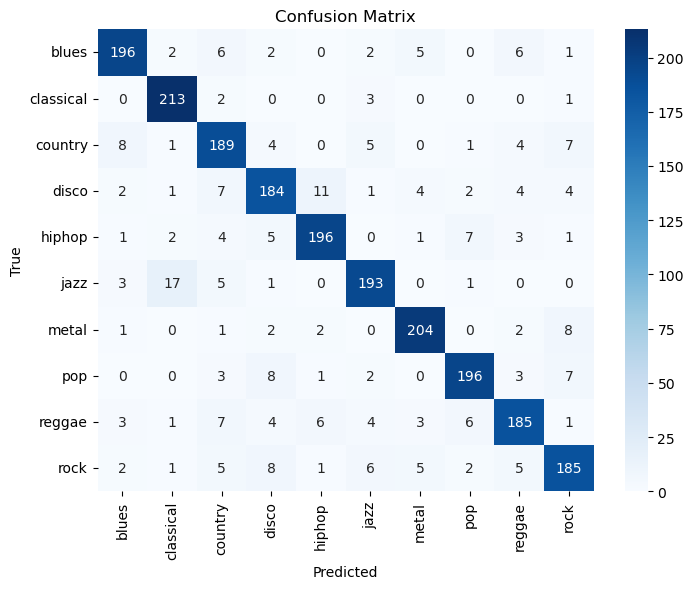

In [16]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
labels = combined_data.label.unique()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Feature Importance

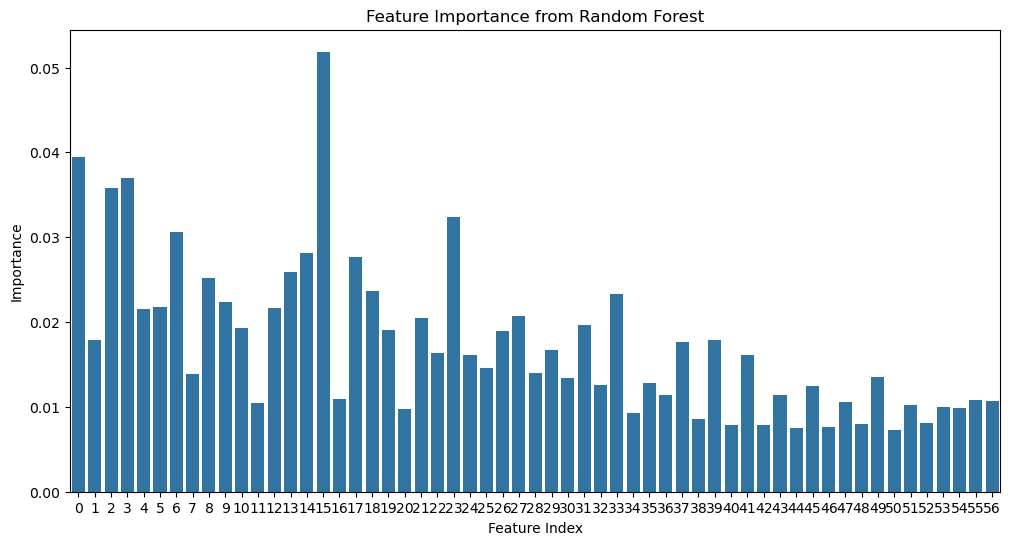

In [17]:
# Feature Importance Visualization
# Get feature importances
feature_importance = rf.feature_importances_

# Plot heatmap of feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=list(range(len(feature_importance))), y=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

## Hyperparameter Tuning

In this step I chose a few parameters that can be used to test different combinations, in the hopes of finding the optimal combination that will produce the highest accuracy.


- n_estimators: Represents the number of trees in the forest. More trees typically improve performance but increase computational cost.
- max_depth: Limits the depth of each tree. small depth can reduce overfitting, whereas a larger one can capture more complexity. I used [10,20,None] to explore shallow, moderately deep, and fully grown trees. Giving me a full range of possibilites.
- min_samples_split: Represent the minimum number of samples required to split a node. This helps control the growth of each tree to prevent overfitting.
- min_samples_leaf: Represents the minimum number of samples required to remain in a leaf. Similarly to the min_samples_split, this controls the growth of each tree to try prevent overfitting.
<br>

A 3-fold corss-validation was used during tuning to validate the model on different subsets of data, ensuring that the results generalise well across unseen data.
<br>

Accuracy was chosen as the optimisation metric for simplicity, as genre classification is a balanced problem with equal representation across classes.


In [35]:
# Start Timer
start = time.time()

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

# Best parameters and accuracy
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_

# Evaluate on the test set
best_y_pred = best_estimator.predict(X_test)
best_accuracy = accuracy_score(y_test, best_y_pred)
best_report = classification_report(y_test, best_y_pred, target_names=label_encoder.classes_)

print(f"Best Parameters: {best_params}")
print(f"Tuned Accuracy: {best_accuracy}\n")
print(f"Tuned Classification Report:\n{best_report}")

# End and print timer
end = time.time()
time_taken = round(end - start, 3)
print(f"Time taken: {time_taken} seconds")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Accuracy: 0.8930846223839854

Tuned Classification Report:
              precision    recall  f1-score   support

       blues       0.93      0.91      0.92       220
   classical       0.89      0.96      0.93       219
     country       0.83      0.88      0.86       219
       disco       0.88      0.84      0.86       220
      hiphop       0.91      0.90      0.90       220
        jazz       0.89      0.88      0.88       220
       metal       0.94      0.93      0.93       220
         pop       0.92      0.89      0.90       220
      reggae       0.87      0.87      0.87       220
        rock       0.87      0.87      0.87       220

    accuracy                           0.89      2198
   macro avg       0.89      0.89      0.89      2198
weighted avg       0.89      0.89      0.89      2198

Time take

## Analysis

The initial model gave an accuracy of 88.3%, then 89.3% after the hyperparameter tuning. This level of accuracy is robust, considering that this is a multi-class classification problem involving several distinct genres. Additionally, the model achieved strong performance, with F1-scores ranging from 0.84 to 0.93, although genres with overlapping features, like rock and pop, showed slightly reduced precision and recall due to their complexity and similarity.
<br>
<br>
Random forest inherently provides feature importance scores, which can help identify which audio features contribute most to genre prediction. Metrics such as spectral centroid, chroma features, and MFCCs are likely to dominate the importance rankings, due to their strong correlation with key characteristics of music genres.
<br>
<br>
In conclusion, the model performs very well, achieving high accuracy and balanced precision recall across all genres. Hyperparameter tuning further refined the model's ability to generalise. This was also my first time implementing a grid search for hyperparameter tuning. This gave me a better understanding not only of the grid-search method, but also of the Random Forest's parameters. 

# MLP Neural Network

MLPS (Multi-Layer Perceptrons) are particularly well-suited for structured tabular data where the relationships between features are complex and non-linear. Unlike traditional linear models, MLPs utilise multiple layers of neurons and non-linear activation functions to capture intricate interactions between features, enabling them to model dependencies that may not be immediately apparent. This makes them effective for tasks like song genre classification, where features such as tempo and loudness might combine in subtle ways to influence the outcome (Multilayer Perceptron Explained And How To Train & Optimise MLPs, 2024).  
<br>
I chose to use two hidden layers with 128 and 64 neurons using the ReLU activation. These sizes provide a balance between model complexity and computational efficiency. Two layers allow the model to learn deeper feature interactions.

## Load in Data

In [55]:
# Read the datasets
data_3_sec = pd.read_csv("features_3_sec.csv")
data_30_sec = pd.read_csv("features_30_sec.csv")

## Preprocessing



In [58]:
# Drop irrelevant columns
data_3_sec_clean = data_3_sec.drop(columns=['filename', 'length'])
data_30_sec_clean = data_30_sec.drop(columns=['filename', 'length'])

# Separate features and labels
X_3_sec = data_3_sec_clean.drop(columns=['label'])
y_3_sec = data_3_sec_clean['label']

X_30_sec = data_30_sec_clean.drop(columns=['label'])
y_30_sec = data_30_sec_clean['label']

# Encode labels
label_encoder = LabelEncoder()
y_3_sec_encoded = label_encoder.fit_transform(y_3_sec)
y_30_sec_encoded = label_encoder.transform(y_30_sec)

# Standardize features
scaler = StandardScaler()
X_3_sec_scaled = scaler.fit_transform(X_3_sec)
X_30_sec_scaled = scaler.transform(X_30_sec)

# Check the shape of preprocessed data
X_3_sec_scaled.shape, y_3_sec_encoded.shape, X_30_sec_scaled.shape, y_30_sec_encoded.shape


((9990, 57), (9990,), (1000, 57), (1000,))

## Split Data

In [60]:
# Split the 3-second dataset into train and test sets
X_train_3_sec, X_test_3_sec, y_train_3_sec, y_test_3_sec = train_test_split(
    X_3_sec_scaled, y_3_sec_encoded, test_size=0.2, random_state=42, stratify=y_3_sec_encoded
)

# Split the 30-sec dataset into train and test sets
X_train_30_sec, X_test_30_sec, y_train_30_sec, y_test_30_sec = train_test_split(
    X_30_sec_scaled, y_30_sec_encoded, test_size=0.2, random_state=42, stratify=y_30_sec_encoded
)

# Check the shape of training and testing sets
(X_train_3_sec.shape, X_test_3_sec.shape, y_train_3_sec.shape, y_test_3_sec.shape,
 X_train_30_sec.shape, X_test_30_sec.shape, y_train_30_sec.shape, y_test_30_sec.shape)


((7992, 57),
 (1998, 57),
 (7992,),
 (1998,),
 (800, 57),
 (200, 57),
 (800,),
 (200,))

## Train Model

In [68]:
# Initialize the MLPClassifier
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers: 128 and 64 neurons
    activation='relu',  # ReLU activation function
    solver='adam',  # Adam optimizer
    max_iter=200,  # Maximum epochs
    batch_size=32,  # Batch size
    random_state=42  # For reproducibility
)

# Train the model on the 3-second dataset
mlp_classifier.fit(X_train_3_sec, y_train_3_sec)

# Evaluate the model
accuracy_3_sec = mlp_classifier.score(X_test_3_sec, y_test_3_sec)

# Generate a classification report
y_pred_3_sec = mlp_classifier.predict(X_test_3_sec)
report_3_sec = classification_report(y_test_3_sec, y_pred_3_sec, target_names=label_encoder.classes_)

accuracy_3_sec, report_3_sec = mlp_classifier.score(X_test_3_sec, y_test_3_sec), classification_report(y_test_3_sec, y_pred_3_sec, target_names=label_encoder.classes_)

print("--- 3 Second Initial MLP ---")
print(f"Initial Accuracy: {accuracy_3_sec}\n")
print(f"Classification Report:\n{report_3_sec}")

--- 3 Second Initial MLP ---
Initial Accuracy: 0.8758758758758759

Classification Report:
              precision    recall  f1-score   support

       blues       0.87      0.88      0.88       200
   classical       0.94      0.94      0.94       199
     country       0.82      0.80      0.81       199
       disco       0.86      0.86      0.86       200
      hiphop       0.92      0.88      0.90       200
        jazz       0.89      0.92      0.90       200
       metal       0.87      0.97      0.92       200
         pop       0.94      0.85      0.89       200
      reggae       0.83      0.89      0.86       200
        rock       0.84      0.78      0.81       200

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



## Hyperparameter Tuning

### Grid Search
I used a grid search for hyperparameter tuning, allowing me to evaluate lots of variations of my neural network. One of the parameters I experiemented with was the sizes of the hidden layers. Using a large hidden layer can indicate a complex relationship between features and labels. The alpha parameter indicates the regularisation strength in mitigating overfitting. Because the grid search suggested a higher alpha value, this could suggest overfitting was an issue with the smaller values (Hyperparameter Tuning With Grid Search: A Practical Guide).

In [77]:
# Start Timer
start = time.time()

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32), (128, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # Regularization strength
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the MLPClassifier
mlp_tuning = MLPClassifier(max_iter=200, batch_size=32, random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=mlp_tuning, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_3_sec, y_train_3_sec)

# Display the best parameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"\nTuned Score: {best_score}\n")

# End and print timer
end = time.time()
time_taken = round(end - start, 3)
print(f"Time taken: {time_taken} seconds")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 128), 'learning_rate': 'constant', 'solver': 'adam'}

Tuned Score: 0.8757507507507508

Time taken: 412.226 seconds


### Cross-Dataset Evaluation
With the help of the parameters from the grid search, I implimented a cross-dataset evaluation to further increase the accuracy of the model. This greatly increased the accuracy score to 99%, suggesting very little error in classifiying the songs into generes. The precision, recall, and F1-scores for all 10 classes are near perfect (mostly 1.00), with only minor variations in a few classes like hiphop, jazz, and reggae, which have slightly lower scores (around 0.95-0.98). Both weighted and macro averages for precison, recall, and F1-score are 0.99, indicating no significant performance discrepancies across different classes.

In [89]:
# Train on 3-second dataset
mlp_cross_eval = MLPClassifier(**best_params, max_iter=200, random_state=42)
mlp_cross_eval.fit(X_train_3_sec, y_train_3_sec)

# Evaluate on 30-second dataset
cross_accuracy = mlp_cross_eval.score(X_test_30_sec, y_test_30_sec)
cross_predictions = mlp_cross_eval.predict(X_test_30_sec)
cross_report = classification_report(y_test_30_sec, cross_predictions, target_names=label_encoder.classes_)

print(f"\nCross Accuracy: {cross_accuracy}")
print(f"\nClassification Report:\n{cross_report}")


Cross Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        20
   classical       1.00      0.95      0.97        20
     country       1.00      0.95      0.97        20
       disco       1.00      1.00      1.00        20
      hiphop       1.00      1.00      1.00        20
        jazz       0.95      1.00      0.98        20
       metal       1.00      1.00      1.00        20
         pop       1.00      1.00      1.00        20
      reggae       0.95      1.00      0.98        20
        rock       1.00      1.00      1.00        20

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



## Visualisations 

### Feature Importance

In [98]:
# Calculate permutation importance
perm_importance = permutation_importance(mlp_cross_eval, X_test_3_sec, y_test_3_sec, n_repeats=10, random_state=42)
feature_importances = pd.DataFrame({
    'Feature': X_3_sec.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(f"Feature Importance: \n{feature_importances}")

Feature Importance: 
                    Feature  Importance
17               mfcc1_mean    0.132783
15             perceptr_var    0.105455
14            perceptr_mean    0.094094
21               mfcc3_mean    0.081381
23               mfcc4_mean    0.079780
2                  rms_mean    0.073624
0          chroma_stft_mean    0.071572
19               mfcc2_mean    0.069720
4    spectral_centroid_mean    0.067518
10  zero_crossing_rate_mean    0.063564
13              harmony_var    0.062863
6   spectral_bandwidth_mean    0.058609
12             harmony_mean    0.057057
37              mfcc11_mean    0.054555
33               mfcc9_mean    0.053453
25               mfcc5_mean    0.043644
49              mfcc17_mean    0.041141
27               mfcc6_mean    0.040841
3                   rms_var    0.038989
39              mfcc12_mean    0.037738
5     spectral_centroid_var    0.037487
7    spectral_bandwidth_var    0.037287
29               mfcc7_mean    0.034434
43              mfc

### Confusion Matrix

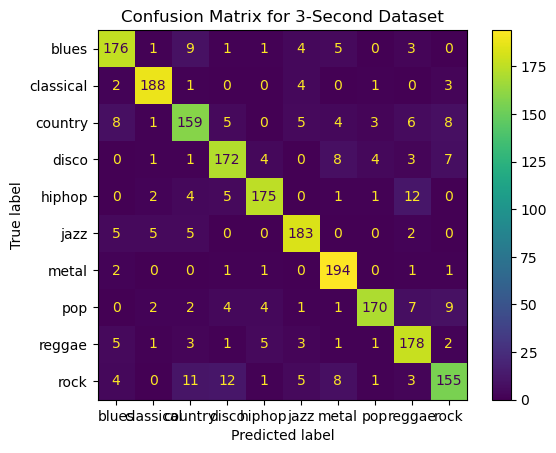

In [103]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_3_sec, y_pred_3_sec, display_labels=label_encoder.classes_, cmap='viridis')
plt.title('Confusion Matrix for 3-Second Dataset')
plt.show()

### Learning Curve Visualization

In [ ]:
# Extract training history
history = mlp_classifier.loss_curve_

# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(history)), history, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Comparison

This notebook aimed to determine which machine learning model performs best for song classification between Random Forest and MLP Neural Networks. Both models have their strengths and weaknesses that allow them to come to different conclusions about the data, however, as the main goal for the models was to accurately classify the songs, I will be taking the F1-Score and Accuracy Score as the main metrics for my evaluation. 
<br>
<br>
Random Forest is an ensemble learning method, meaning it combines the predictions of multiple individual models, in this case decision trees, to produce a final result. This approach leverages the 'wisdom of the crowd' principle, where the aggregated predictions of several models are generally more robust and accurate than a single model (Ensemble Methods and Wisdom of the Crowd, 2023). The model performed well with an initial accuracy of 88%, then with some tuning slightly improving to 89%. For the hyperparameter tuning of this model, I used a GridSearch. This allowed me to explore a variety of parameters as well as implement a 3-fold cross-validation to find the best outline for the model. Creating and training this model gave me good insights into the workings of the Random Forest model, giving me more confidence in its implementation in future projects.  
<br>
MLP Neural Networks excel at capturing intricate, non-linear relationships in data (Dash, T. Behera, H.S., 2015). With multiple layers and non-linear activation functions, they can model subtle interactions between features, which are common in music data where genres may depend on complex combinations of features.  Similarly to the Random Forest model, I utilised the GridSearch method for hyperparameter tuning. Therefore, with the help of cross-dataset evaluation, the model rose from an accuracy of 87.59% to 99%. Although the final Accuracy of the model gave a staggering 99% accuracy, Neural Networks are often harder to interpret and can be difficult to understand how different features contribute to the output.
<br>
<br>
In conclusion, exploring both models provided valuable insight into the machine learning pipeline and helped me reach a clear answer to my research question. After conducting multiple tests, the MLP Neural Network model consistently achieved the highest accuracy. Therefore, I consider it the most effective of the two for genre classification.

# References
- Dash, T. and Behera, H.S. (2015) A Fuzzy MLP Approach for Non-Linear Pattern Classification. In: Vanugopal, K.R. and Lingareddy, S.C. eds. *International Conference on Communication and Computing (ICC-2014)*. Bangalore, India, 12-14 June 2014. Computer Networks and Security, pp. 314-323.
- Geeks for Geeks (2023) *Ensemble Methods and Wisdom of the Crowd*. Available from: https://www.geeksforgeeks.org/ensemble-methods-and-wisdom-of-the-crowd/ [Accessed 10 December 2024].
- Code Max (No Date) *Hyperparameter Tuning With Grid Search: A Practical Guide*. Available from: https://codemax.app/snippet/hyperparameter-tuning-with-grid-search-a-practical-guide/ [Accessed 12 December 2024].
- Spot Intelligence (2024) *Multilayer Perceptron Explained And How To Train & Optimise MLPs*. Available from: https://spotintelligence.com/2024/02/20/multilayer-perceptron-mlp/ [Accessed 11 December 2024].
- Parmar, A., Katariya, R. and Patel, V. (2018) A Review on Random Forest: An Ensemble Classifier. In: Gemanth, J., Fernando, X., Lafata, P., Baig, Z. eds. *International Conference on Intelligent Data Communication Technologies and Internet of Things (ICICI) 2018*. Springer, Cham. pp 758-763.